In [26]:
import pandas as pd
import numpy as np
import re

In [6]:
df = pd.read_csv("../data/Summer22_FootballTransfers.csv", parse_dates=["date_of_transfer"])

In [94]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

df.head()

Shape: (33825, 13)

Columns: ['name', 'position', 'age', 'origin_club', 'league_origin_club', 'country_origin_club', 'new_club', 'league_new_club', 'country_new_club', 'player_value', 'cost', 'date_of_transfer', 'fee_million_eur']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33825 entries, 0 to 33824
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 33825 non-null  object        
 1   position             33824 non-null  object        
 2   age                  33674 non-null  float64       
 3   origin_club          33825 non-null  object        
 4   league_origin_club   32903 non-null  object        
 5   country_origin_club  32903 non-null  object        
 6   new_club             33825 non-null  object        
 7   league_new_club      28351 non-null  object        
 8   country_new_club     28351 non-null  object        
 9   player_value         

,name,position,age,origin_club,league_origin_club,country_origin_club,new_club,league_new_club,country_new_club,player_value,cost,date_of_transfer,fee_million_eur
0,Amine Gouiri,Centre-Forward,22.0,OGC Nice,Ligue 1,France,Stade Rennais FC,Ligue 1,France,€42.00m,€28.00m,2022-09-01,28.0
1,Umar Sadiq,Centre-Forward,25.0,UD Almería,LaLiga,Spain,Real Sociedad,LaLiga,Spain,€18.00m,€20.00m,2022-09-01,20.0
2,Carlos Soler,Central Midfield,25.0,Valencia CF,LaLiga,Spain,Paris Saint-Germain,Ligue 1,France,€50.00m,€18.00m,2022-09-01,18.0
3,Manuel Akanji,Centre-Back,27.0,Borussia Dortmund,Bundesliga,Germany,Manchester City,Premier League,England,€30.00m,€17.50m,2022-09-01,17.5
4,Wout Faes,Centre-Back,24.0,Stade Reims,Ligue 1,France,Leicester City,Premier League,England,€10.00m,€17.00m,2022-09-01,17.0


In [96]:
#converting values from €Xm to X

def fee_to_million_eur(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).lower().strip()

    if "free" in s or "loan" in s: 
        return 0.0
    if any(t in s for t in ["n/a", "?", "-"]): 
        return np.nan

    has_currency = ("€" in s) or ("eur" in s)
    s = s.replace("€","").replace(",","")
    m = re.match(r"^\s*([\d\.]+)\s*([mk])?\s*$", s)
    
    if not m:
        return np.nan

    num, unit = float(m.group(1)), m.group(2)
    if unit == "m": 
        return num
        
    if unit == "k": 
        return num/1000.0
        
    return num/1_000_000.0 if has_currency else np.nan



df["fee_million_eur"] = df["cost"].apply(fee_to_million_eur)
df[["cost", "fee_million_eur"]].head(15)

,cost,fee_million_eur
0,€28.00m,28.0
1,€20.00m,20.0
2,€18.00m,18.0
3,€17.50m,17.5
4,€17.00m,17.0
5,€15.00m,15.0
6,€15.00m,15.0
7,€12.00m,12.0
8,€11.00m,11.0
9,€10.40m,10.4


In [98]:
#editing columns
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

df.rename(columns={"player_valuje": "player_value"}, inplace=True)

print(df.columns.tolist())

['name', 'position', 'age', 'origin_club', 'league_origin_club', 'country_origin_club', 'new_club', 'league_new_club', 'country_new_club', 'player_value', 'cost', 'date_of_transfer', 'fee_million_eur']


In [100]:
top10 = (

    df.sort_values("fee_million_eur", ascending=False).head(10)[["name", "new_club", "origin_club", "fee_million_eur"]]    
)
top10

,name,new_club,origin_club,fee_million_eur
1275,Antony,Manchester United,Ajax Amsterdam,95.00
725,Wesley Fofana,Chelsea FC,Leicester City,80.40
19425,Aurélien Tchouameni,Real Madrid,AS Monaco,80.00
19426,Darwin Núñez,Liverpool FC,SL Benfica,75.00
2950,Casemiro,Manchester United,Real Madrid,70.65
1900,Alexander Isak,Newcastle United,Real Sociedad,70.00
12900,Matthijs de Ligt,Bayern Munich,Juventus FC,67.00
6500,Marc Cucurella,Chelsea FC,Brighton & Hove Albion,65.30
19427,Erling Haaland,Manchester City,Borussia Dortmund,60.00
15300,Raphinha,FC Barcelona,Leeds United,58.00


In [102]:
#Transfer spending by clubs

club_spending = (
    df.groupby("new_club")["fee_million_eur"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)
club_spending

new_club
Chelsea FC                 278.99
Manchester United          238.02
West Ham United            182.00
Tottenham Hotspur          169.90
Nottingham Forest          156.00
FC Barcelona               153.00
Paris Saint-Germain        147.50
Manchester City            139.50
Bayern Munich              137.50
Wolverhampton Wanderers    136.60
Name: fee_million_eur, dtype: float64

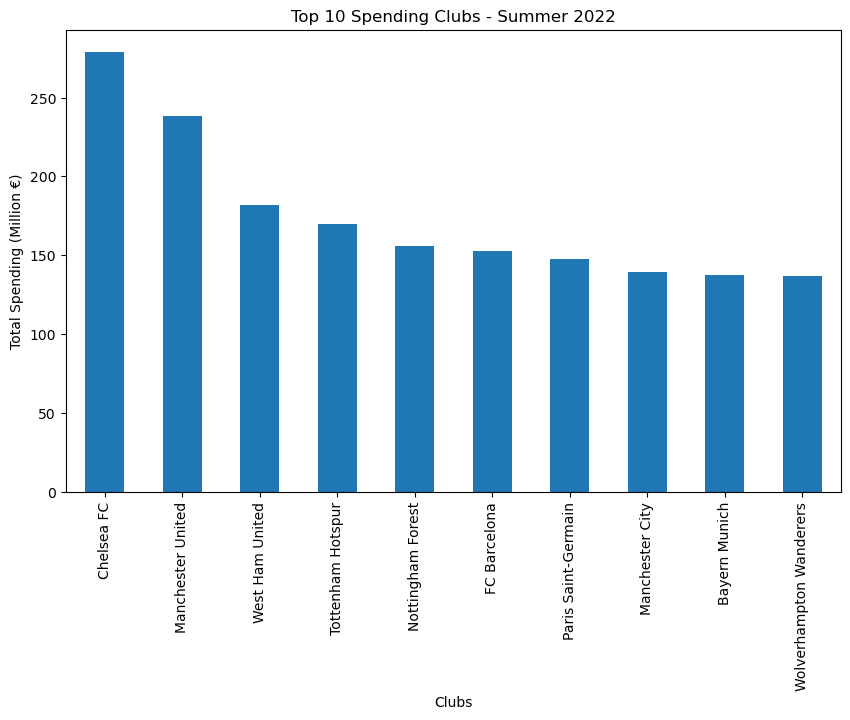

In [179]:
#Plot of transfer spending by clubs

import matplotlib.pyplot as plt

club_spending.head(10).plot(kind="bar", figsize=(10,6))
plt.title("Top 10 Spending Clubs - Summer 2022")
plt.ylabel("Total Spending (Million €)")
plt.xlabel("Clubs")
plt.savefig("../visuals/top10_clubs.png", dpi=300, bbox_inches="tight")
plt.show()


## We can see that Premier League teams are dominating the top 10 spending, with 6 teams. Chelsea is leading with 279M€. 


In [20]:
top10 = (

    df.sort_values("fee_million_eur", ascending=False).head(10)[["name", "new_club", "origin_club", "fee_million_eur"]]    
)

top10

,name,new_club,origin_club,fee_million_eur
5060,Kofi Balmer,Crystal Palace U21,Larne FC,300.00
1275,Antony,Manchester United,Ajax Amsterdam,95.00
725,Wesley Fofana,Chelsea FC,Leicester City,80.40
19425,Aurélien Tchouameni,Real Madrid,AS Monaco,80.00
19426,Darwin Núñez,Liverpool FC,SL Benfica,75.00
2950,Casemiro,Manchester United,Real Madrid,70.65
1900,Alexander Isak,Newcastle United,Real Sociedad,70.00
12900,Matthijs de Ligt,Bayern Munich,Juventus FC,67.00
6500,Marc Cucurella,Chelsea FC,Brighton & Hove Albion,65.30
19427,Erling Haaland,Manchester City,Borussia Dortmund,60.00


In [106]:
#Transfer spending by leagues

league_spending = (
    df.groupby("league_new_club")["fee_million_eur"]
      .sum()
      .sort_values(ascending=False)
)
league_spending.head(10)

league_new_club
Premier League        2220.55
Serie A                699.73
Ligue 1                552.00
Bundesliga             513.35
LaLiga                 500.36
Liga Portugal          165.10
Eredivisie             154.60
Jupiler Pro League     107.39
Süper Lig               91.88
Championship            75.75
Name: fee_million_eur, dtype: float64

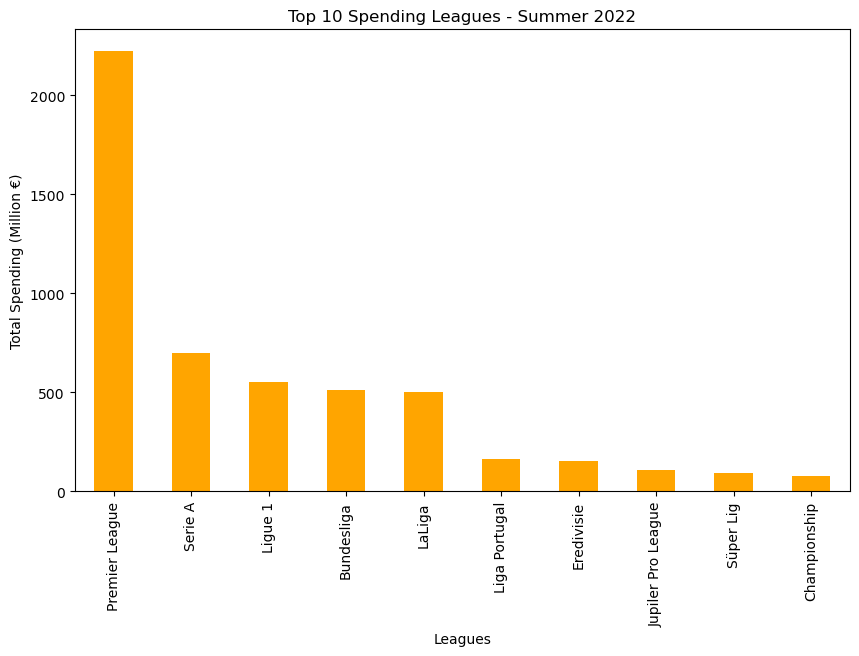

In [171]:
#Plot of transfer spending by leagues

league_spending.head(10).plot(kind="bar", figsize=(10,6), color="orange")
plt.title("Top 10 Spending Leagues - Summer 2022")
plt.ylabel("Total Spending (Million €)")
plt.xlabel("Leagues")

plt.savefig("../visuals/top10_leagues.png", dpi=300, bbox_inches="tight")
plt.show()


In [108]:
#Average transfer fees

avg_fee = df["fee_million_eur"].mean()
avg_fee_over1m = df.loc[df["fee_million_eur"] >= 1, "fee_million_eur"].mean()

print("Average fee (m€):", round(avg_fee, 2))
print("Average fee of 1M+ transfers (m€):", round(avg_fee_over1m, 2))

Average fee (m€): 0.25
Average fee of 1M+ transfers (m€): 7.46


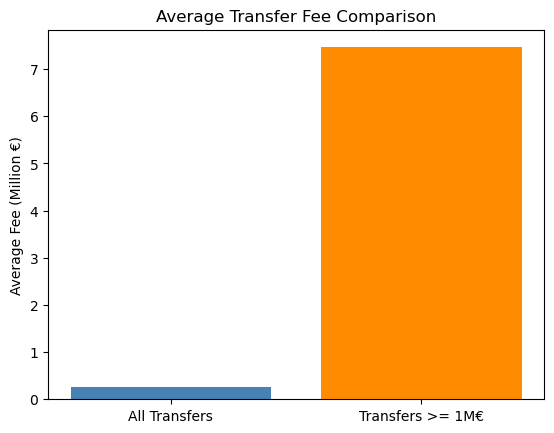

In [165]:
#Plot of average transfer fees

plt.bar(["All Transfers", "Transfers >= 1M€"], 
        [avg_fee, avg_fee_over1m], 
        color=["steelblue","darkorange"])
plt.title("Average Transfer Fee Comparison")
plt.ylabel("Average Fee (Million €)")
plt.savefig("../visuals/average_fee.png", dpi=300, bbox_inches="tight")
plt.show()

## The average fee of all transfers is very low since there are many low-value transfers. 
## If we ignore the ones under 1M€, the average is 7.46M€.

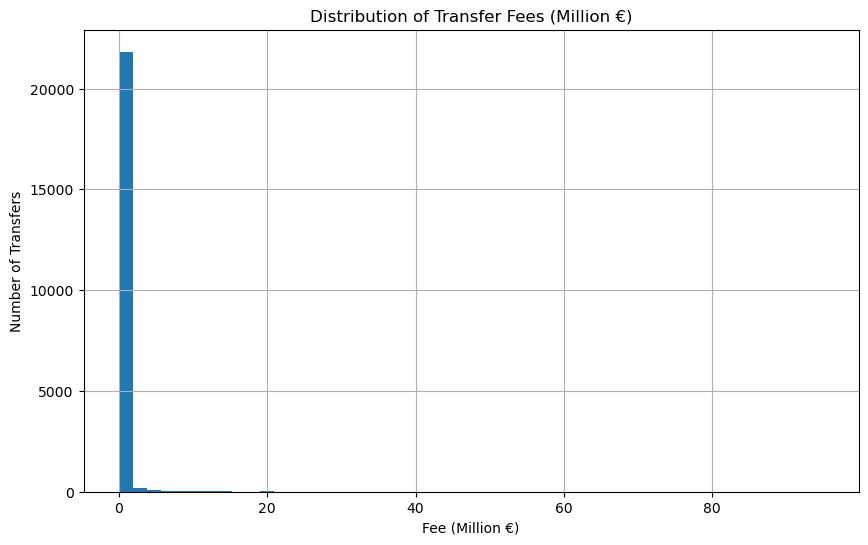

In [167]:
#Distribution of transfer fees

df["fee_million_eur"].hist(bins=50, figsize=(10,6))
plt.title("Distribution of Transfer Fees (Million €)")
plt.xlabel("Fee (Million €)")
plt.ylabel("Number of Transfers")
plt.savefig("../visuals/dist_of_fee.png", dpi=300, bbox_inches="tight")
plt.show()

In [153]:
#Number of players bought by clubs

club_new_player_count = (
    df[df["fee_million_eur"] >= 1]
    .groupby("new_club")["name"]
      .count()
      .sort_values(ascending=False)
)

club_new_player_count.head(20)

new_club
Nottingham Forest      14
US Salernitana 1919    12
UD Almería              9
Olympique Marseille     8
West Ham United         8
Hellas Verona           8
Udinese Calcio          8
Chelsea FC              7
Club Brugge KV          7
Trabzonspor             7
Galatasaray A.S.        7
Feyenoord Rotterdam     7
Ajax Amsterdam          7
US Sassuolo             7
Sporting CP             7
AC Monza                7
OGC Nice                7
SL Benfica              6
Royal Antwerp FC        6
SS Lazio                6
Name: name, dtype: int64

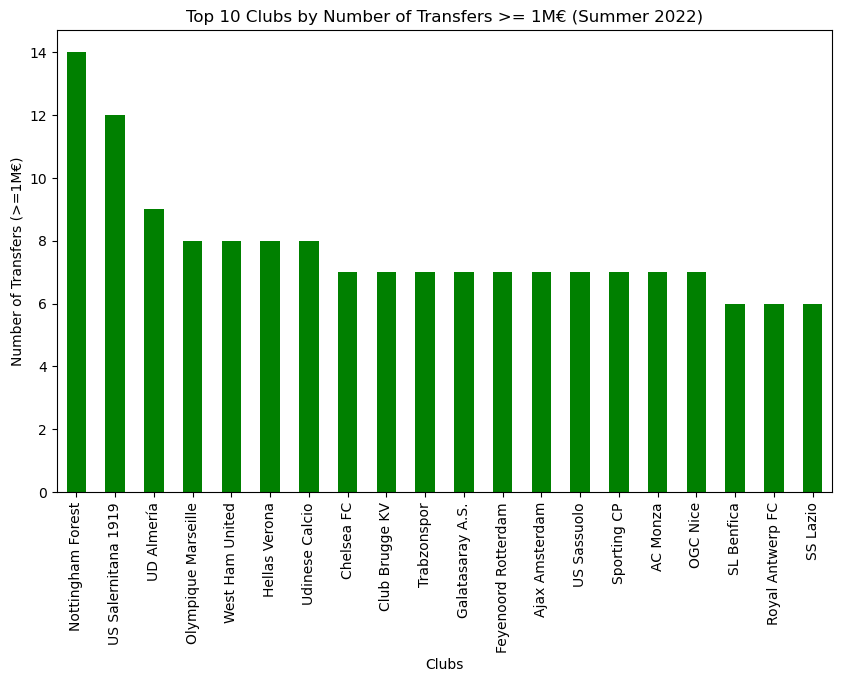

In [177]:
#Top 10 clubs by new players bought

club_new_player_count.head(20).plot(kind="bar", figsize=(10,6), color="green")
plt.title("Top 10 Clubs by Number of Transfers >= 1M€ (Summer 2022)")
plt.ylabel("Number of Transfers (>=1M€)")
plt.xlabel("Clubs")
plt.savefig("../visuals/top10_clubs_by_number.png", dpi=300, bbox_inches="tight")
plt.show()

## It can be observed that Nottingham Forest recreated its squad from zero since they were promoted to the Premier League.,

## Chelsea is not a surprise, given that they have spent 279M€.

## Salernitana have struggled to stay in Serie A. That may be the reason for their crucial squad change.

In [ ]:
plt.savefig("../visuals/top10_clubs.png", dpi=300, bbox_inches="tight")
